In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [18]:
!wget -O NFLX.csv https://www.dropbox.com/s/cas9zxws8b0wb7u/NFLX.csv?dl=0

--2019-09-07 11:08:09--  https://www.dropbox.com/s/cas9zxws8b0wb7u/NFLX.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cas9zxws8b0wb7u/NFLX.csv [following]
--2019-09-07 11:08:09--  https://www.dropbox.com/s/raw/cas9zxws8b0wb7u/NFLX.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6fc7cc388f4ffeaf10e0b247ec.dl.dropboxusercontent.com/cd/0/inline/AoHEHorGZtgxGhnaqn_wfBv5k40201kWdncZny4Mteuz4hbmqidP7O6MbtPDZQCBTZ4rED7YWht6dkn8wWoMfti7n8RHcmvlnJG4xEq9NetjSP8xif2mMBLgjVvYUAbf_Dw/file# [following]
--2019-09-07 11:08:09--  https://uc6fc7cc388f4ffeaf10e0b247ec.dl.dropboxusercontent.com/cd/0/inline/AoHEHorGZtgxGhnaqn_wfBv5k40201kWdncZny4Mteuz4hbmqidP7O6MbtPDZQCBTZ4rED7YWht6dkn8wWoMfti7n8RHcmvlnJG4xEq9NetjSP8xif2mMBLgj

In [0]:
df = pd.read_csv('NFLX.csv')

In [20]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-07,342.200012,355.750000,341.250000,348.679993,348.679993,9105800
2018-09-10,352.269989,352.500000,343.079987,348.410004,348.410004,5752200
2018-09-11,344.670013,356.149994,343.899994,355.929993,355.929993,6198100
2018-09-12,359.079987,370.429993,356.239990,369.950012,369.950012,10480800
2018-09-13,371.910004,374.089996,366.839996,368.149994,368.149994,8366100


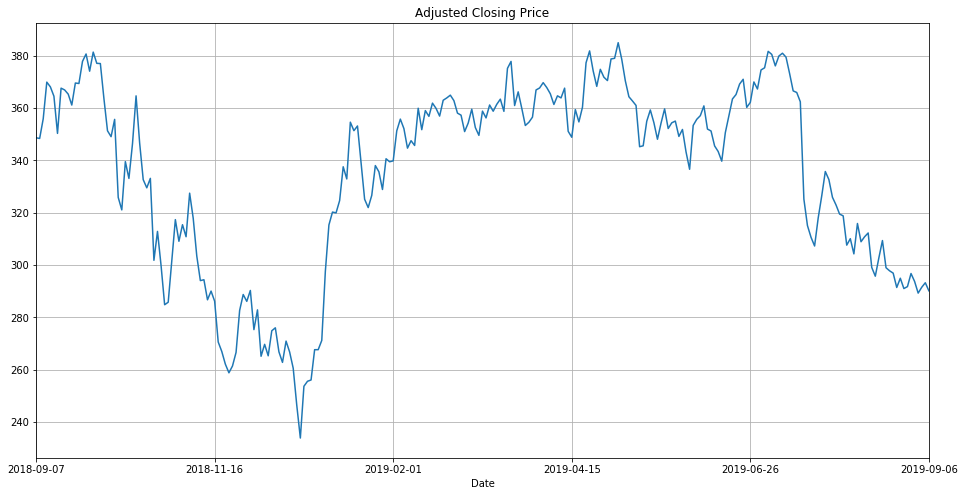

In [21]:
df['Adj Close'].plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

**Ridge Rgeression**

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

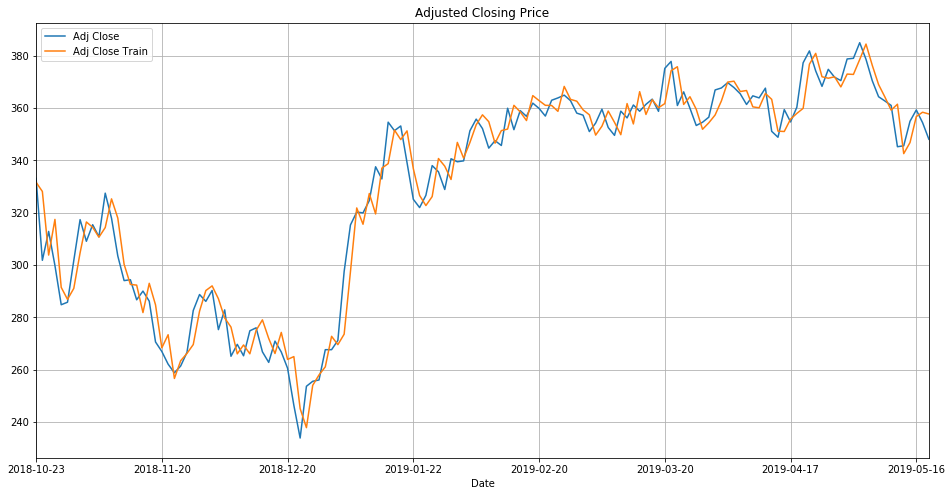

In [27]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

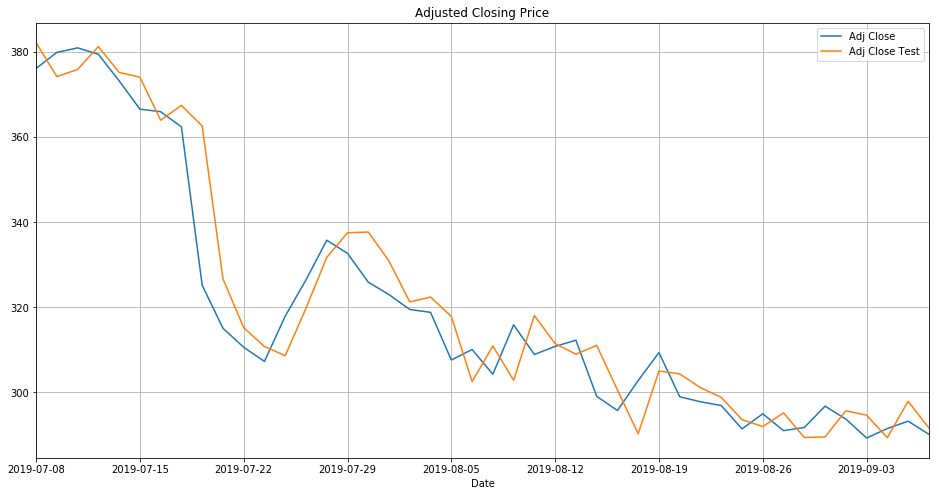

In [28]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

**Gradient Boosting trees**

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

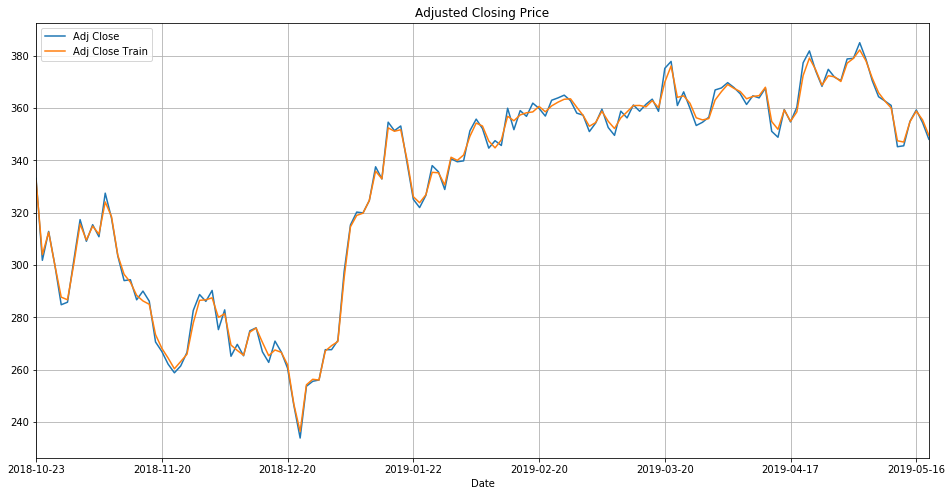

In [30]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

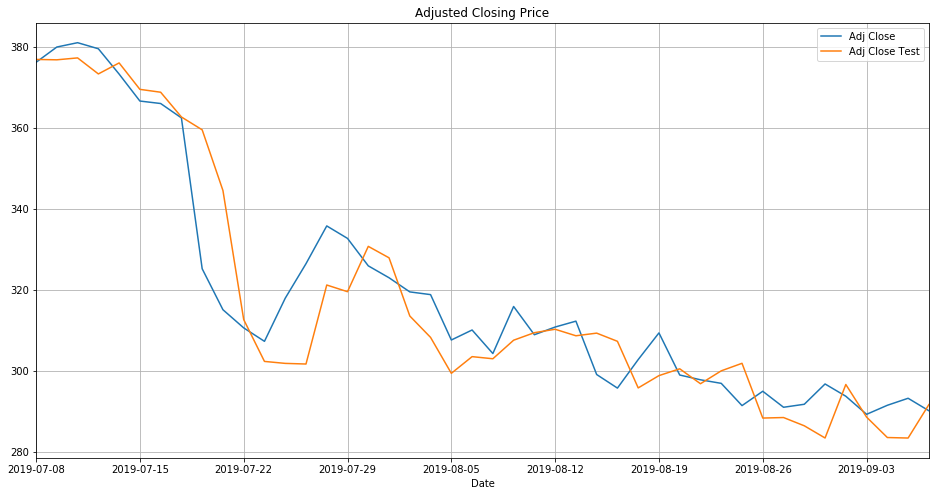

In [32]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

**neural networks with 1D convolutional and LSTM layers**

In [33]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

In [34]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [35]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 175 samples, validate on 44 samples
Epoch 1/250
175/175 [==============================] - 2s 14ms/step - loss: 0.2364 - mean_absolute_error: 0.6325 - val_loss: 0.1068 - val_mean_absolute_error: 0.3352
Epoch 2/250
175/175 [==============================] - 0s 2ms/step - loss: 0.2364 - mean_absolute_error: 0.6325 - val_loss: 0.1068 - val_mean_absolute_error: 0.3352
Epoch 3/250
175/175 [==============================] - 0s 2ms/step - loss: 0.2364 - mean_absolute_error: 0.6325 - val_loss: 0.1068 - val_mean_absolute_error: 0.3352
Epoch 4/250
175/175 [==============================] - 0s 2ms/step - loss: 0.2364 - mean_absolute_error: 0.6325 - val_loss: 0.1068 - val_mean_absolute_error: 0.3352
Epoch 5/250
175/175 [==============================] - 0s 2ms/step - loss: 0.2364 - mean_absolute_error: 0.6325 - val_loss: 0.1068 - val_mean_absolute_error: 0.3352
Epoch 6/250
175/175 [============

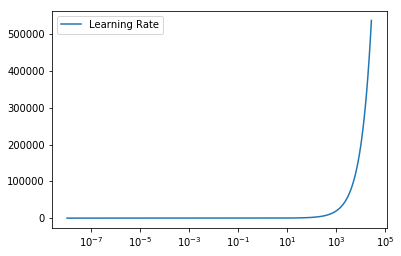

In [36]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

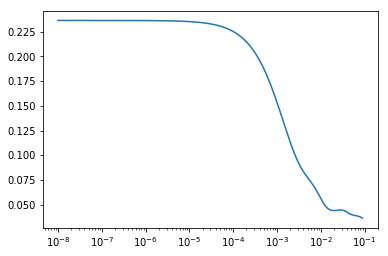

In [37]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [38]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 175 samples, validate on 44 samples
Epoch 1/250
175/175 [==============================] - 2s 11ms/step - loss: 0.1923 - mean_absolute_error: 0.5748 - val_loss: 0.0687 - val_mean_absolute_error: 0.3314
Epoch 2/250
175/175 [==============================] - 0s 2ms/step - loss: 0.1101 - mean_absolute_error: 0.4166 - val_loss: 0.1514 - val_mean_absolute_error: 0.5109
Epoch 3/250
175/175 [==============================] - 0s 2ms/step - loss: 0.1042 - mean_absolute_error: 0.3071 - val_loss: 0.2198 - val_mean_absolute_error: 0.6106
Epoch 4/250
175/175 [==============================] - 0s 2ms/step - loss: 0.1253 - mean_absolute_error: 0.3836 - val_loss: 0.1369 - val_mean_absolute_error: 0.4814
Epoch 5/250
175/175 [==============================] - 0s 2ms/step - loss: 0.0732 - mean_absolute_error: 0.2796 - val_loss: 0.0433 - val_mean_absolute_error: 0.2686
Epoch 6/250
175/175 [==============================] - 0s 2ms/step - loss: 0.0479 - mean_absolute_error: 0.2539 - val_loss: 0.027

 Once we predict the values, we also must reverse the normalization so that we can plot the predictions in the same scale as the original values.



In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare with he original values.



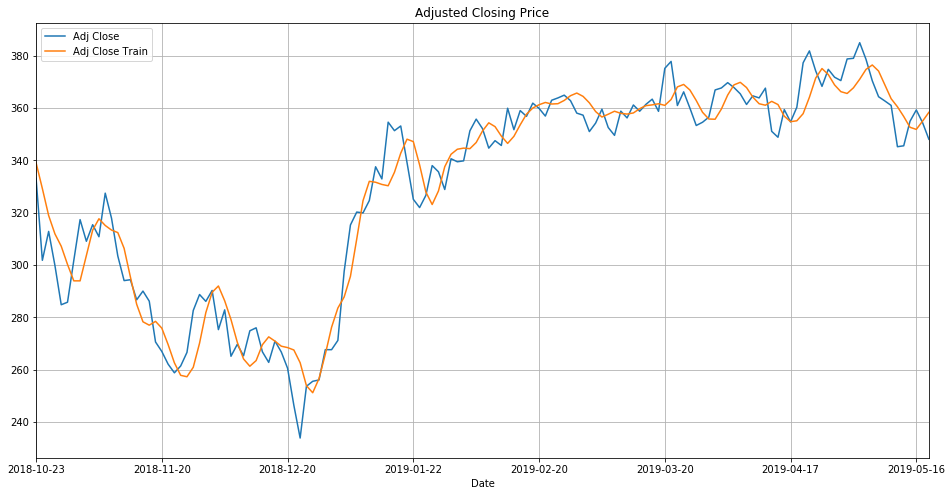

In [40]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

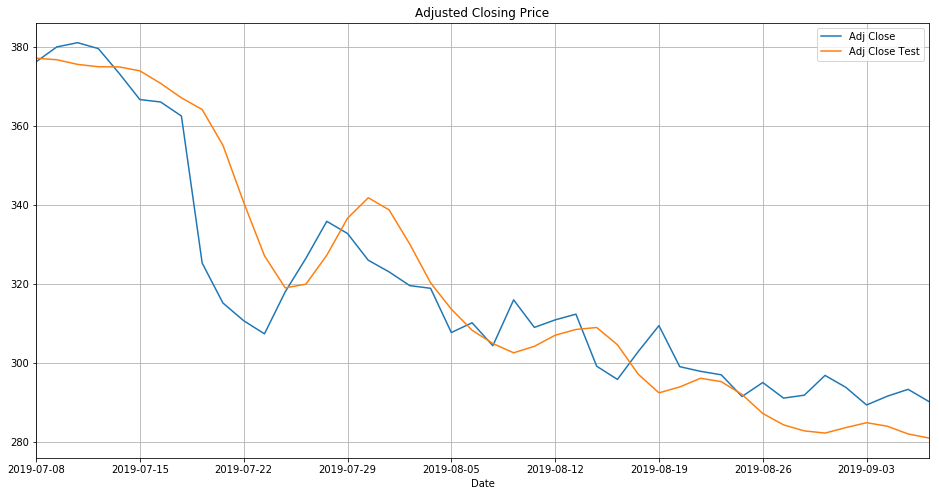

In [41]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

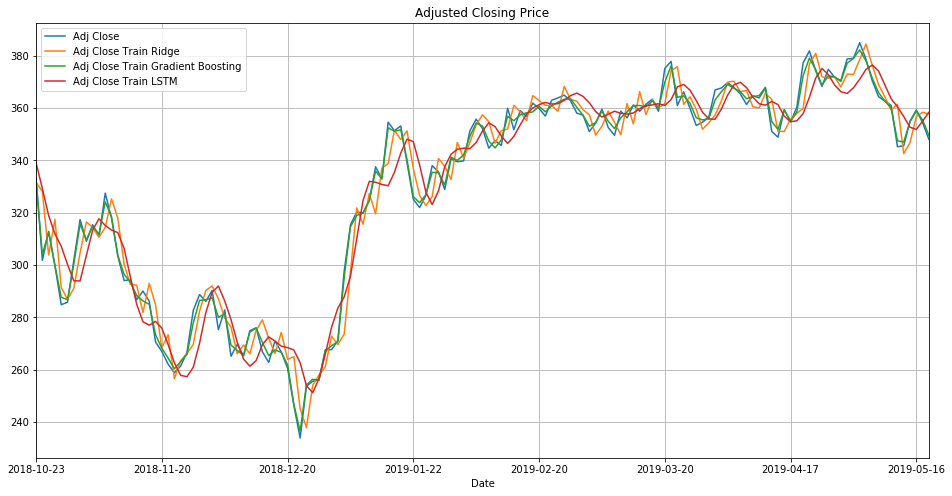

In [42]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='NFLX', figsize=(16,8), title='Adjusted Closing Price', grid=True)

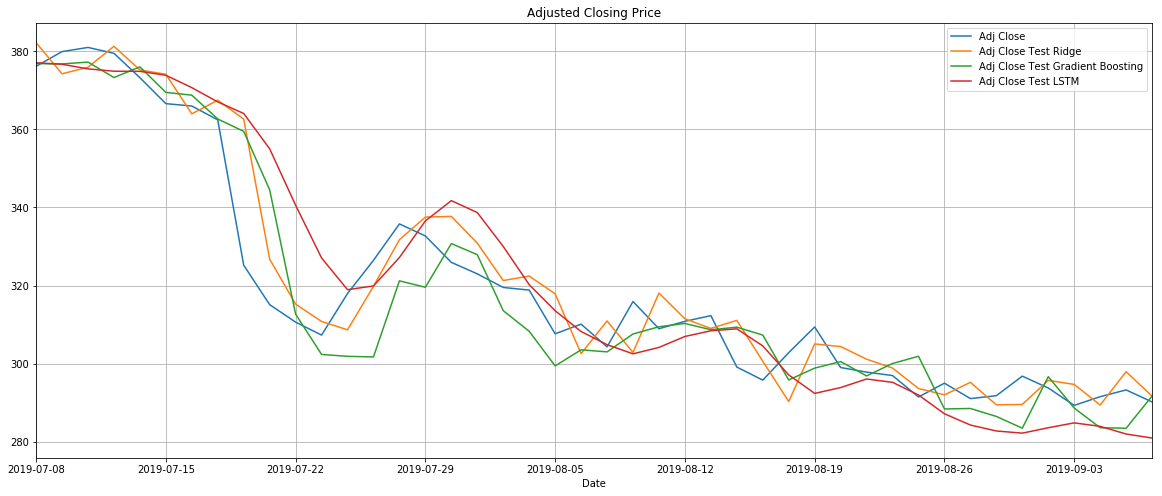

In [44]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='NFLX', figsize=(20,8), title='Adjusted Closing Price', grid=True)